# Working with Reve in Pixeltable

Pixeltable's Reve integration lets you call Reve's `create`, `edit`, and `remix` endpoints directly from tables so you can iterate on visuals without leaving your data workflows.

## What is Reve?

Reve is an image generation/editing service with three API endpoints:

- **`create`**: Generate new images from text prompts
- **`edit`**: Edit existing images with natural language instructions
- **`remix`**: Blend multiple images together

### Documentation

- [Pixeltable Reve Functions](https://docs.pixeltable.com/sdk/latest/reve#module-pixeltable-functions-reve)
- [Reve API Reference](https://api.reve.com/console/docs)

## Prerequisites
- A Reve account with an API key (<https://app.reve.com/> → Settings → API Keys)

**Important:** Reve API calls consume credits based on your plan—monitor your usage to avoid unexpected charges. Images sent to Reve are processed on Reve's servers outside your environment, so do not upload sensitive, private, or confidential images.

We'll start by installing Pixeltable, configuring your API key, creating a directory, and setting up a table. Then we'll walk through each Reve endpoint—`create`, `edit`, and `remix`—one at a time.

In [ ]:
%pip install -qU pixeltable

In [ ]:
import os
import getpass

if 'REVE_API_KEY' not in os.environ:
    os.environ['REVE_API_KEY'] = getpass.getpass('Reve API Key: ')

To read more about working with API keys in Pixeltable, see [Configuration](https://docs.pixeltable.com/overview/configuration).

## Setup

In [2]:
import pixeltable as pxt

Create a Pixeltable directory to keep the tables for this demo separate from anything else you're working on.

In [3]:
pxt.create_dir('reve_demo', if_exists='replace_force')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'reve_demo'.


We'll create a Pixeltable table that starts with a prompt and a source image, and ends with a final scene. The table we'll build up to will require two inputs per row:

1. A prompt for creating a background scene image. We'll use this prompt for Reve to create a scene with `reve.create()`.
2. An existing source image. We'll ask Reve to edit this image with `reve.edit()`, and then it will be ready as the foreground image.

Finally, we'll remix the background scene image we made in step 1 by combining it with the foreground image we made in step 2 with `reve.remix()`.

In [4]:
spunk_t = pxt.create_table('reve_demo.solarpunk_scenes', {
    'prompt': pxt.String,
    'source_image': pxt.Image
})

Created table 'solarpunk_scenes'.


To read more about creating tables, see [Tables and Data Operations](https://docs.pixeltable.com/notebooks/fundamentals/tables-and-data-operations).

You can look at the schema for this table:

In [5]:
spunk_t.describe()

<style type="text/css">
#T_14628_row0_col0 {
  white-space: pre-wrap;
  text-align: left;
  font-weight: bold;
}
</style>
<table id="T_14628">
  <thead>
  </thead>
  <tbody>
    <tr>
      <td id="T_14628_row0_col0" class="data row0 col0" >table 'reve_demo.solarpunk_scenes'</td>
    </tr>
  </tbody>
</table>

<style type="text/css">
#T_80c05 th {
  text-align: left;
}
#T_80c05_row0_col0, #T_80c05_row0_col1, #T_80c05_row0_col2, #T_80c05_row1_col0, #T_80c05_row1_col1, #T_80c05_row1_col2 {
  white-space: pre-wrap;
  text-align: left;
}
</style>
<table id="T_80c05">
  <thead>
    <tr>
      <th id="T_80c05_level0_col0" class="col_heading level0 col0" >Column Name</th>
      <th id="T_80c05_level0_col1" class="col_heading level0 col1" >Type</th>
      <th id="T_80c05_level0_col2" class="col_heading level0 col2" >Computed With</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_80c05_row0_col0" class="data row0 col0" >prompt</td>
      <td id="T_80c05_row0_col1" class="data row0 col1" >String</td>
      <td id="T_80c05_row0_col2" class="data row0 col2" ></td>
    </tr>
    <tr>
      <td id="T_80c05_row1_col0" class="data row1 col0" >source_image</td>
      <td id="T_80c05_row1_col1" class="data row1 col1" >Image</td>
      <td id="T_80c05_row1_col2" class="data row1 col2" ></td>
    </tr>
  </tbody>
</table>


Now, we'll insert values for our first row. We need to provide a text prompt for the `reve.create()` function and a source image for the `reve.edit()` function.

In [6]:
scene_prompt = ('Create a scene of lush solarpunk metropolis in the desert '
               'with urban agriculture and an oasis theme.'
               'It should not look like an office park, corporate campus, or an outdoor mall.')
               
image_url = 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000036.jpg'

In [ ]:
spunk_t.insert([{
    'prompt': scene_prompt,
    'source_image': image_url
}])

Inserting rows into `solarpunk_scenes`: 1 rows [00:00, 273.74 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 3 values computed.

To read more about inserting data, see [Bringing Data](https://docs.pixeltable.com/datastore/bringing-data). 

And we can peek at our starter table with a single row:

prompt  \
0  Create a scene of lush solarpunk metropolis in...   

                                        source_image  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
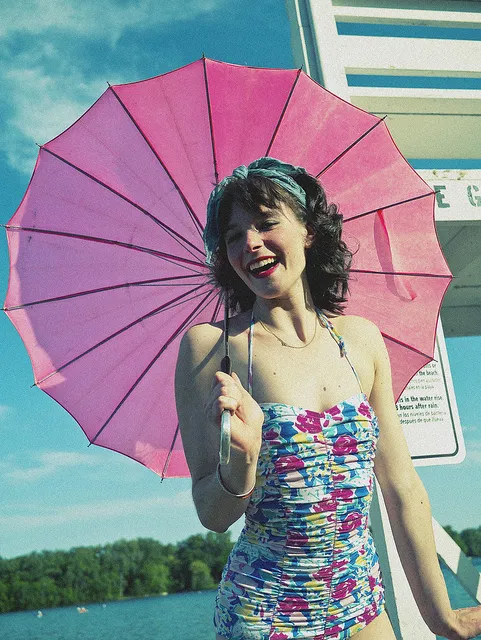

In [8]:
spunk_t.collect()

## Generate new imagery with `reve.create`

Use `reve.create()` when you want Reve to synthesize an entirely new image from a prompt. In Pixeltable, we place this function call inside a computed column. We'll generate fresh imagery from the prompt first in this section. Feel free to change the prompt. Here we ask for a solarpunk oasis city. 

In [9]:
from pixeltable.functions import reve

spunk_t.add_computed_column(
    new_image=reve.create(
        spunk_t.prompt
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

To read more about computed columns in Pixeltable, see [Computed Columns](https://docs.pixeltable.com/notebooks/fundamentals/computed-columns). 

prompt  \
0  Create a scene of lush solarpunk metropolis in...   

                                           new_image  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
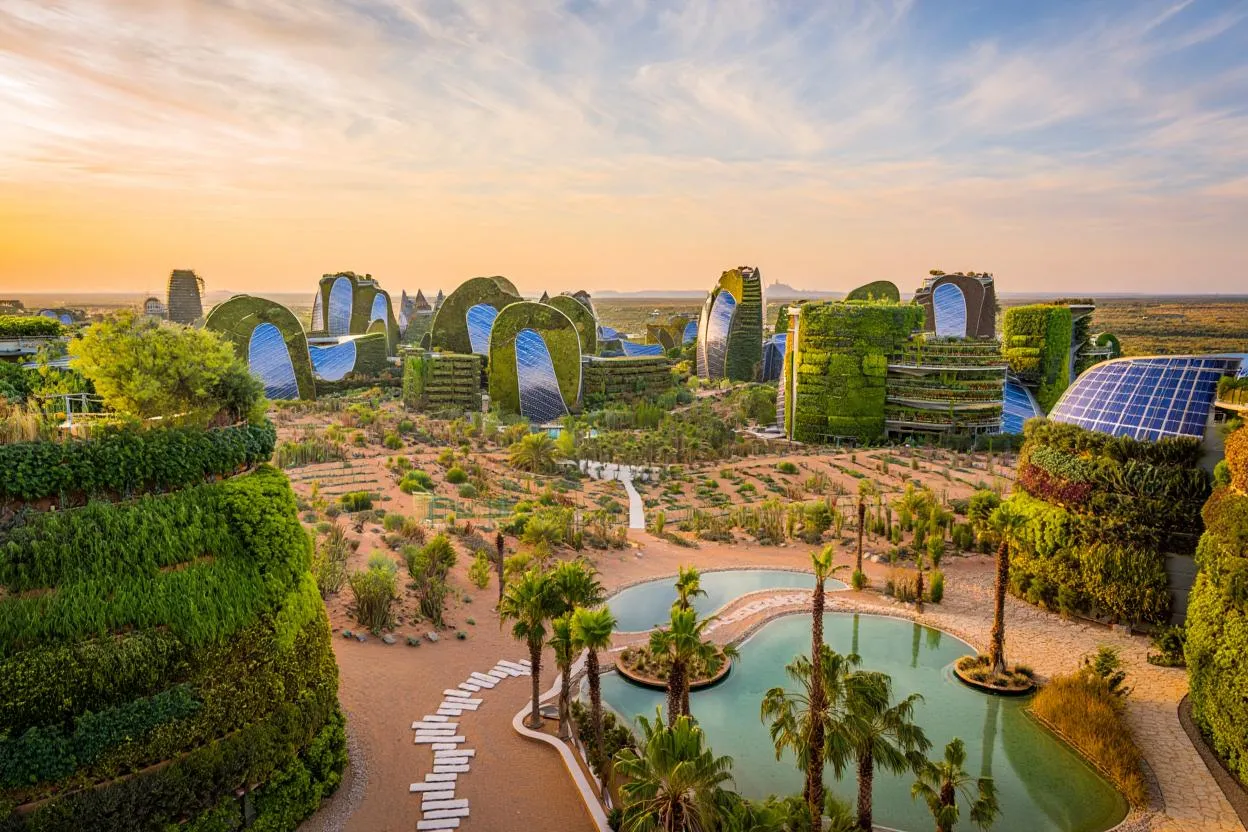

In [11]:
spunk_t.select(spunk_t.prompt, spunk_t.new_image).collect()

By default, Pixeltable saves all generated media outputs to a media directory. We can see the file path by using the `fileurl` property.

In [12]:
spunk_t.select(spunk_t.new_image.fileurl).collect()

new_image_fileurl
0  file:///Users/alison-pxt/.pixeltable/media/865...

### Add Reve parameters

All Reve functions accept optional parameters to customize the output:

- `aspect_ratio`: desired image aspect ratio, e.g. '3:2', '16:9', '1:1', etc. (available for `reve.create()` and `reve.remix()`)
- `version`: specific model version to use (optional; defaults to latest if not specified). Available for all Reve functions (`reve.create()`, `reve.edit()`, and `reve.remix()`)

This adds a second image column using the same prompt that renders in a square frame.


In [13]:
spunk_t.add_computed_column(
    new_image_sq=reve.create(
        spunk_t.prompt,
        aspect_ratio='1:1'
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

prompt  \
0  Create a scene of lush solarpunk metropolis in...   

                                           new_image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                        new_image_sq  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
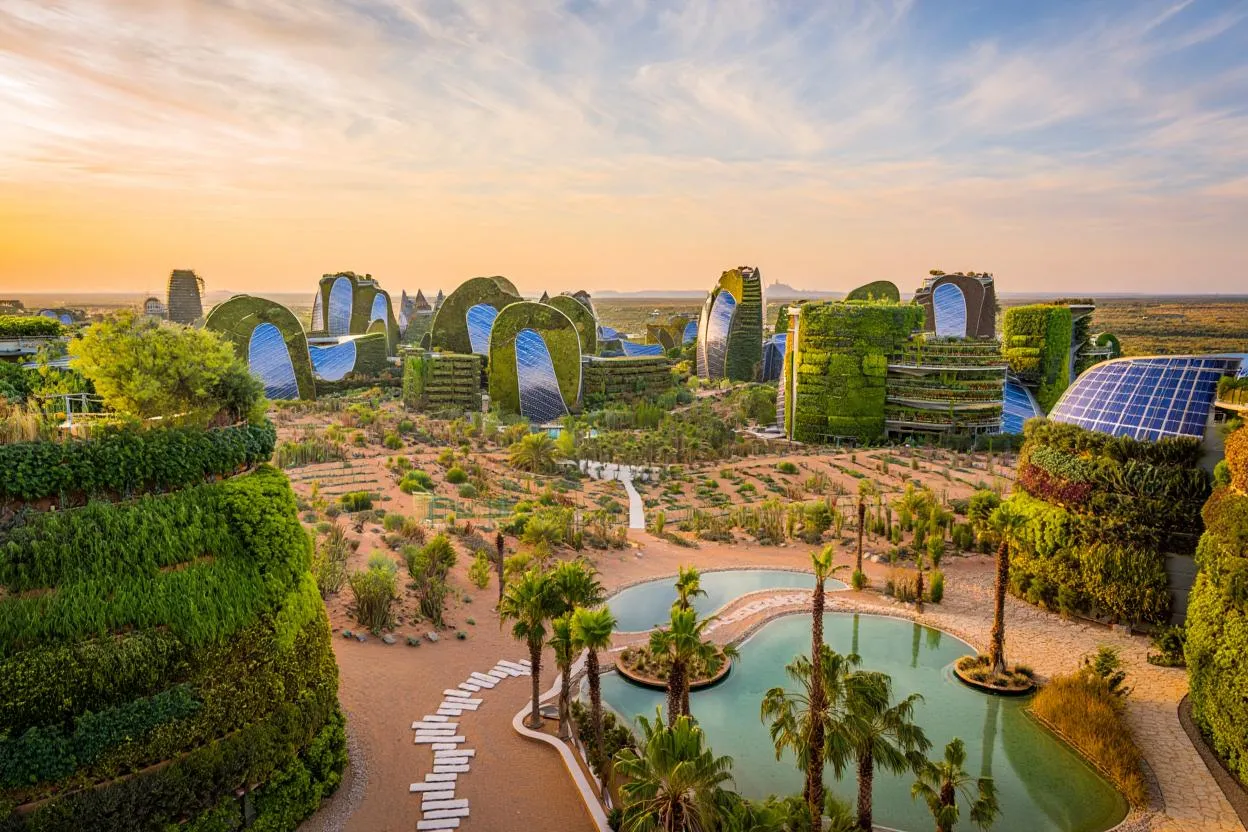
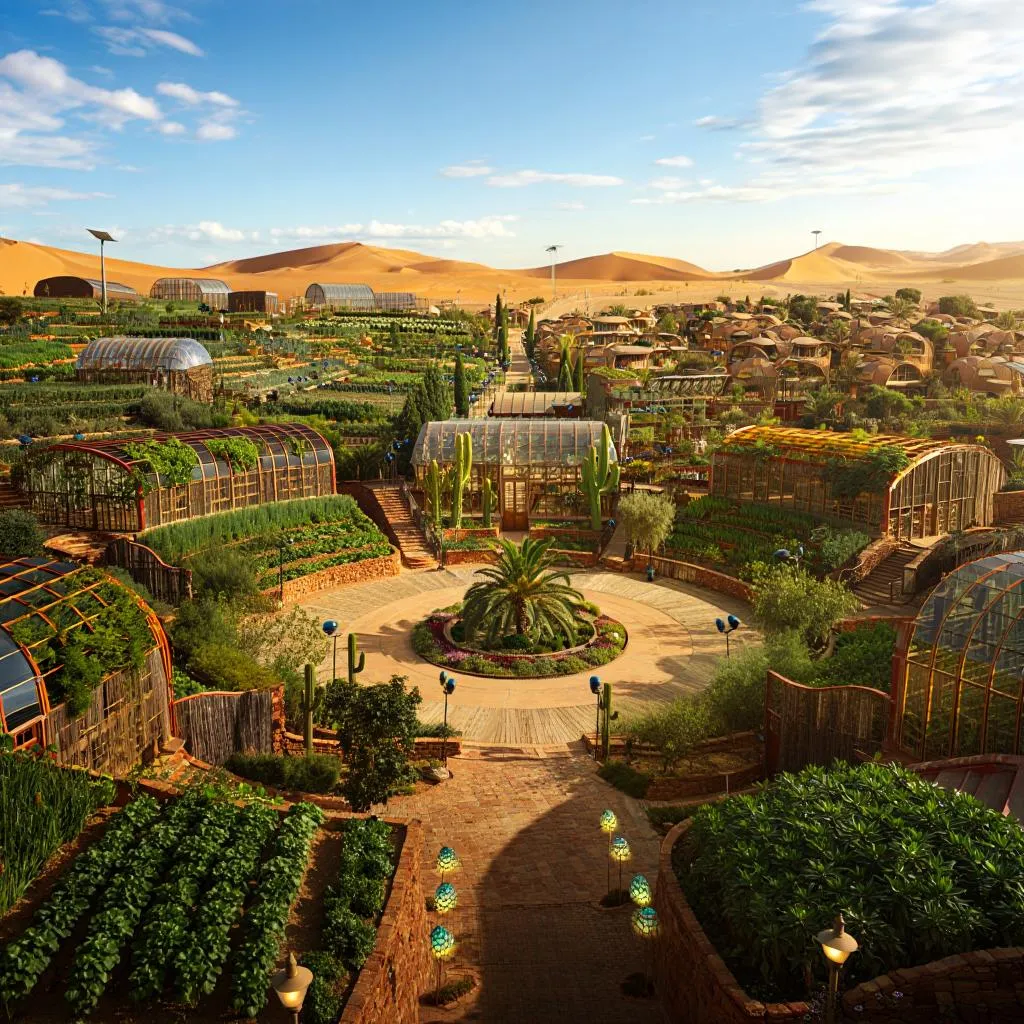

In [14]:
spunk_t.select(spunk_t.prompt, spunk_t.new_image, spunk_t.new_image_sq).collect()

To read more about `reve.create()`, see [reve.create UDF](https://docs.pixeltable.com/sdk/latest/reve#udf-create).

## Edit an existing photo with `reve.edit`

`reve.edit()` takes an existing image plus natural-language instructions and returns an edited version. We already have a `source_image` column in our table from the initial setup. 

source_image
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
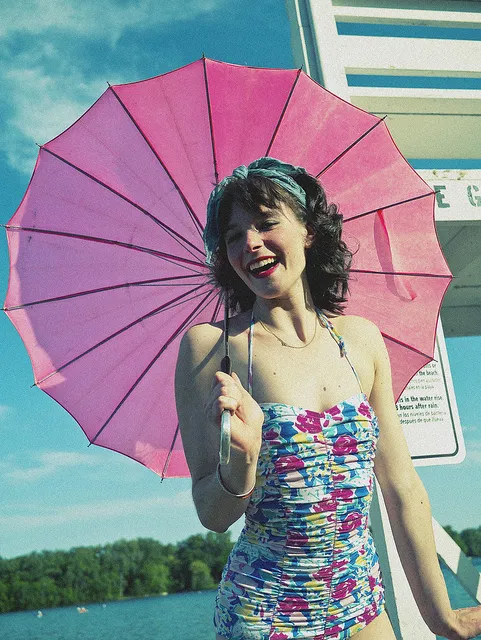

In [16]:
spunk_t.select(spunk_t.source_image).collect()

We can now add a computed column that calls `reve.edit()` to modify the source image. To read more about `reve.edit()`, see [reve.edit UDF](https://docs.pixeltable.com/sdk/latest/reve#udf-edit). 

This editing prompt is integrated into our computed column logic in Pixeltable, as opposed to our creating example where we saved the prompt as its own column. This means that the same prompt will be applied to any new rows that we insert into this table. We will phrase the editing prompt to reflect this table's solarpunk theme, but otherwise keep it general. This way, we don't need to provide a specific prompt for every new table row.

In [17]:
# Uncomment the below line to use a Reve function, if you have not already done so
# from pixeltable.functions import reve

spunk_t.add_computed_column(
    edited_subject=reve.edit(
        spunk_t.source_image,
        'Remove any existing background. Focus on the closest person in the foreground. '
        'Keep the person and props, but make the lighting and colors vibrant and fit with a solarpunk theme. '
    )
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

We can use `collect()` to see the new image:

source_image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                      edited_subject  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
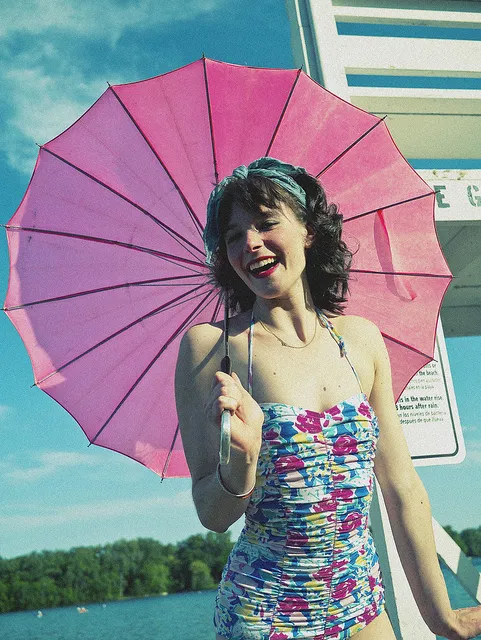
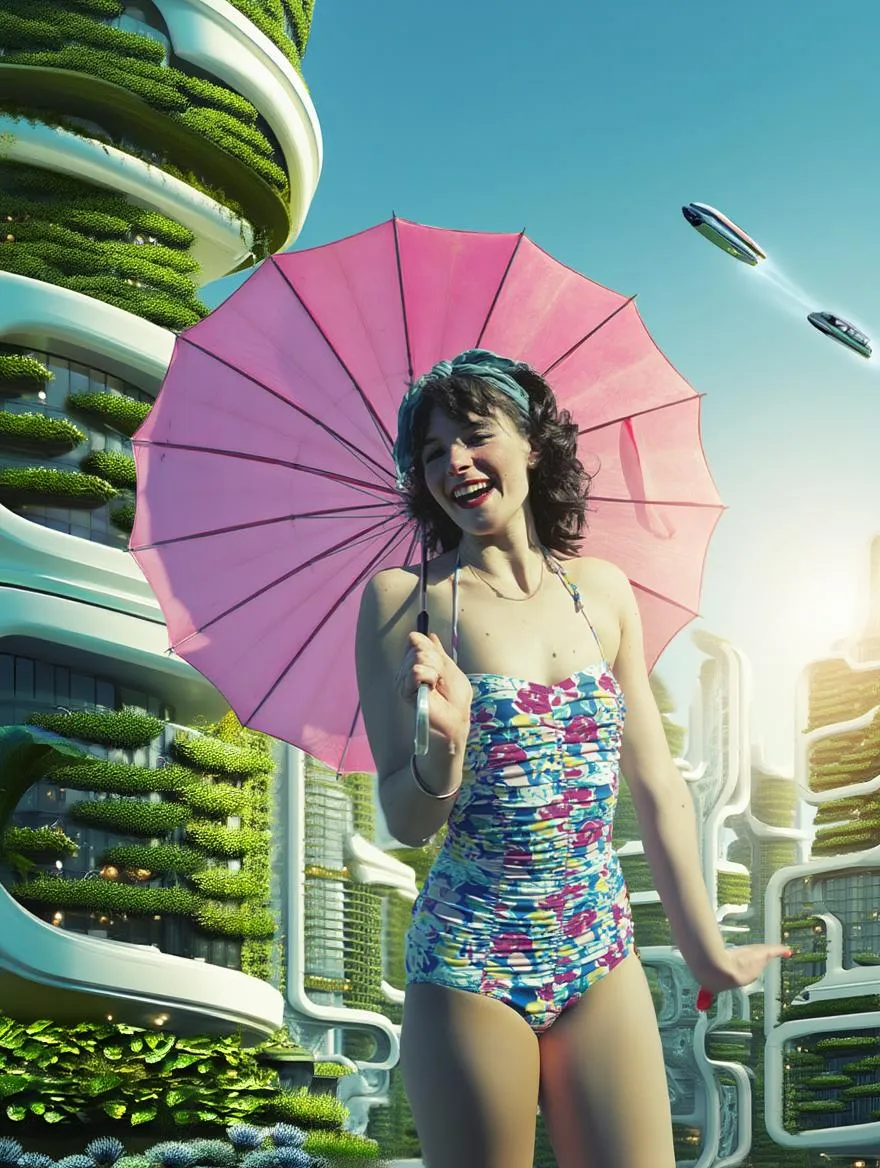

In [18]:
spunk_t.select(spunk_t.source_image, spunk_t.edited_subject).collect()

## Remix multiple references with `reve.remix`

`reve.remix()` blends multiple reference images. Inside the prompt string, you reference each image with a numbered placeholder:
- `<img>0</img>` refers to `images[0]`
- `<img>1</img>` refers to `images[1]`
- etc.

You can optionally specify `aspect_ratio` and `version` parameters (both default to latest/auto if not specified).

In the next cell we place the edited subject from <img>0</img> (the first entry in the images list) into the scene from <img>1</img> (the second entry). 

In [19]:
# Uncomment the below line to use a Reve function, if you have not already done so
# from pixeltable.functions import reve

spunk_t.add_computed_column(
    solarpunk_remix=reve.remix(
        'Place the person in <img>0</img> in the foreground of the scene from <img>1</img>. '
        'Make the background clear and detailed so it feels like a complete "day in the life" in solarpunk city scene.',
        images=[spunk_t.edited_subject, spunk_t.new_image],
        aspect_ratio='16:9',
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

To read more about `reve.remix()`, see [reve.remix UDF](https://docs.pixeltable.com/sdk/latest/reve#udf-remix).

solarpunk_remix
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
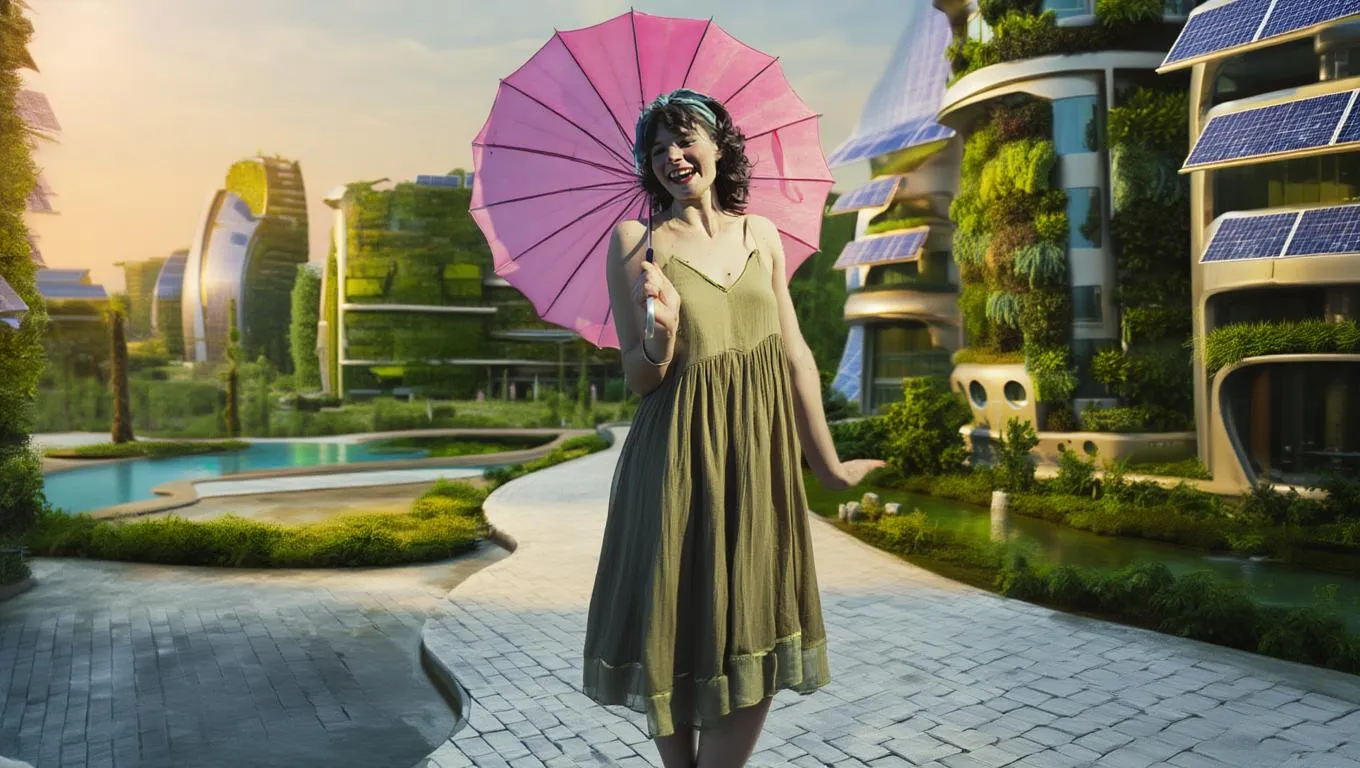

In [20]:
spunk_t.select(spunk_t.solarpunk_remix).collect()

## Insert a new row

So far, we have been building up our table schema with a single row. Now we'll insert a new row, with two fresh input values: 

1. A text prompt to create the scene image with `reve.create()` and
2. A source image to edit with `reve.edit()` and remix into that scene with `reve.remix()`. 

Pixeltable will then automatically make the desired Reve API calls and populate the computed columns.

In [21]:
spunk_t.insert([{
    'prompt': 'Create an indoor tennis court scene, with clay courts inside a lush solarpunk greenhouse filled with bougainvillea, terraced gardens, and an oasis theme.',
    'source_image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000885.jpg'
}])

Inserting rows into `solarpunk_scenes`: 1 rows [00:00, 507.11 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 7 values computed.

Here are our two remixed images created by Reve:

solarpunk_remix
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
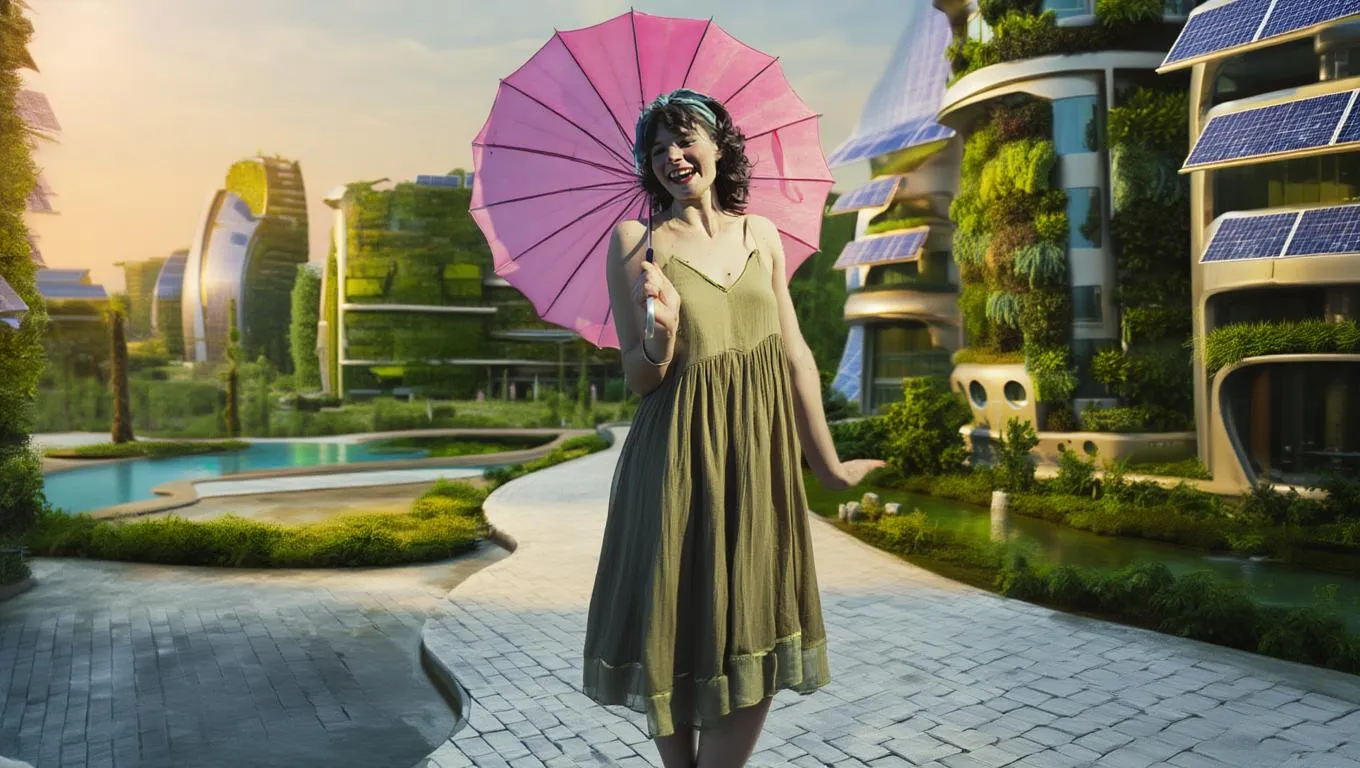
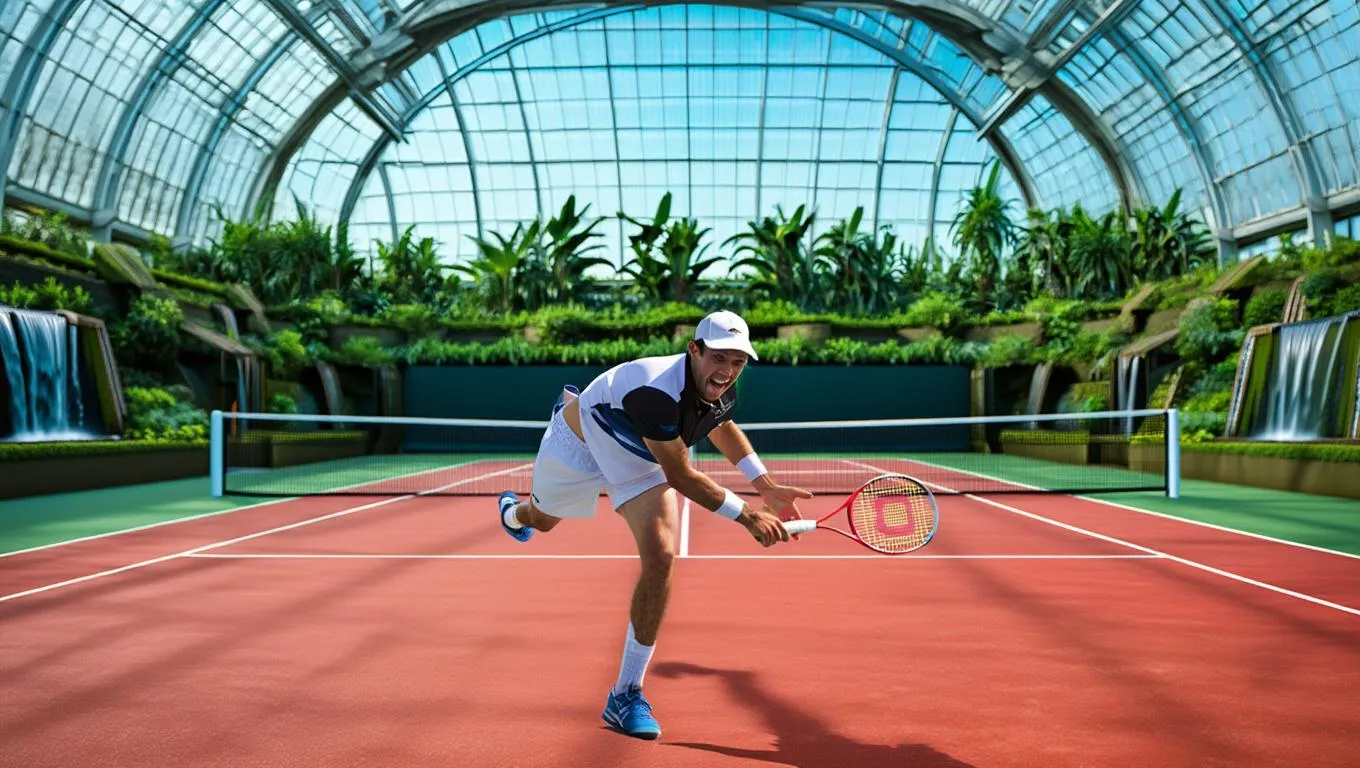

In [22]:
spunk_t.select(spunk_t.solarpunk_remix).collect()

All together, we created a new scene image, edited an existing image of a person, then remixed both together to reimagine an existing person in our new scene.

new_image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                      edited_subject  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                     solarpunk_remix  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
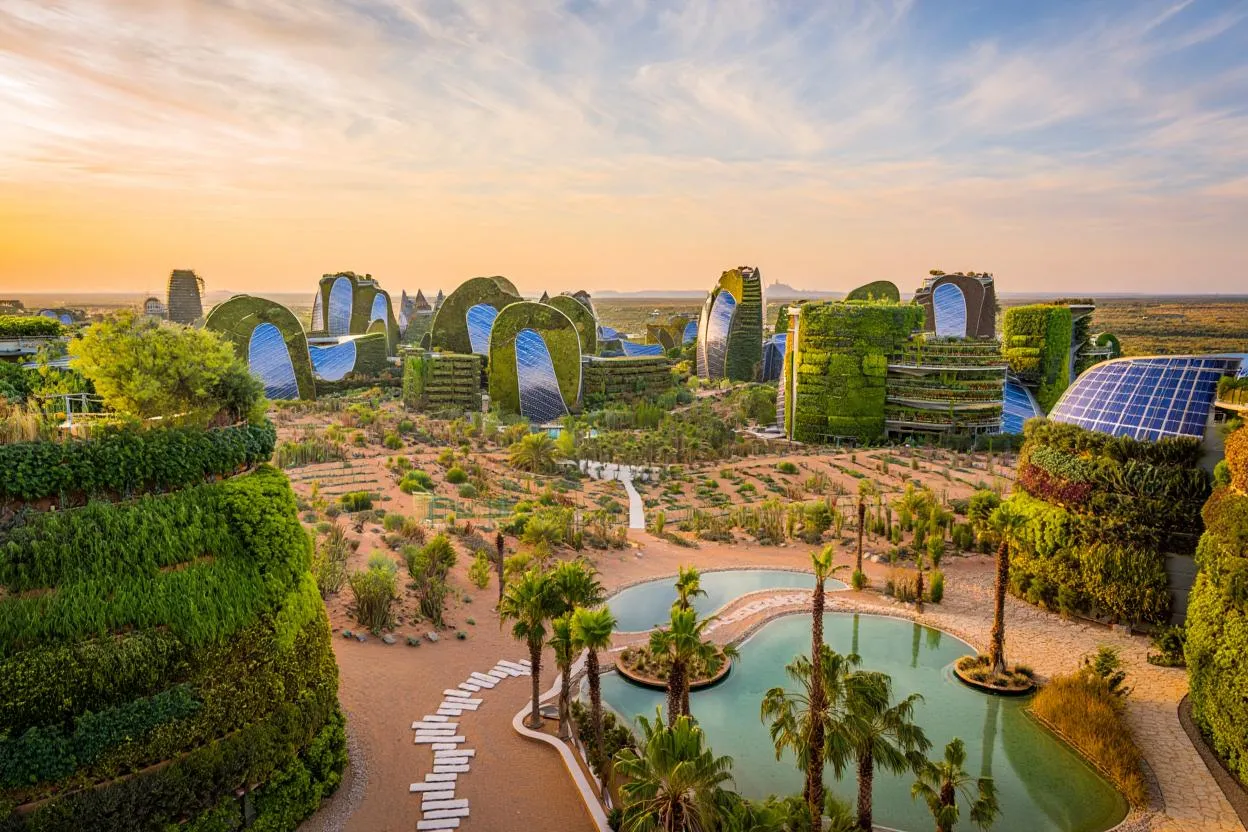
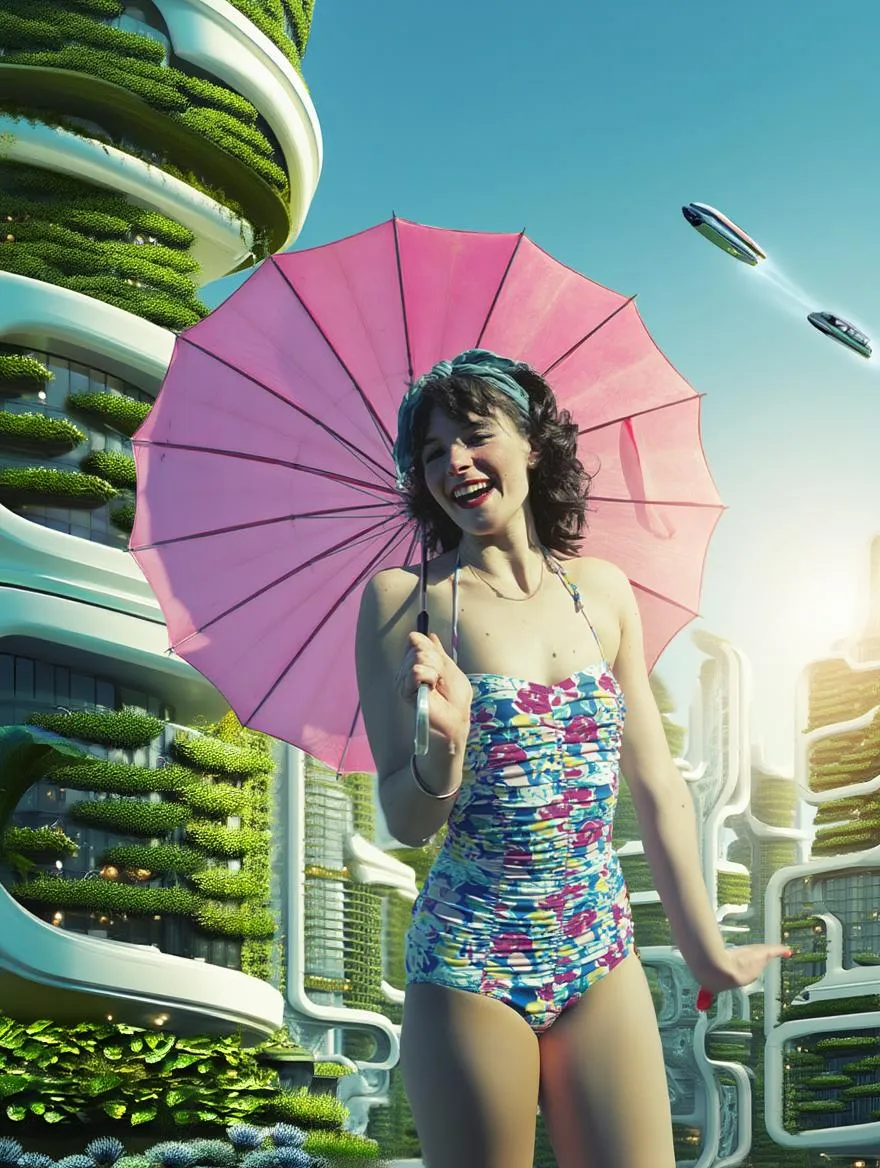
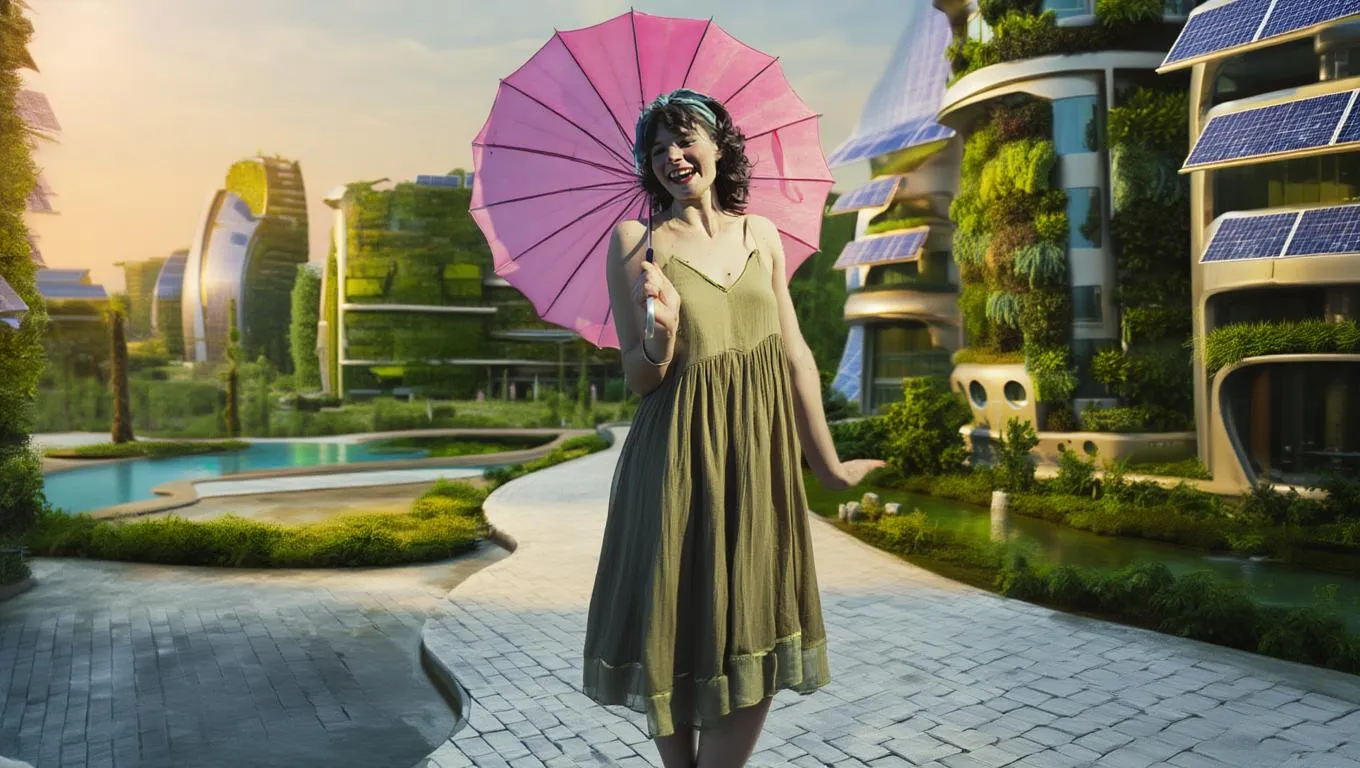
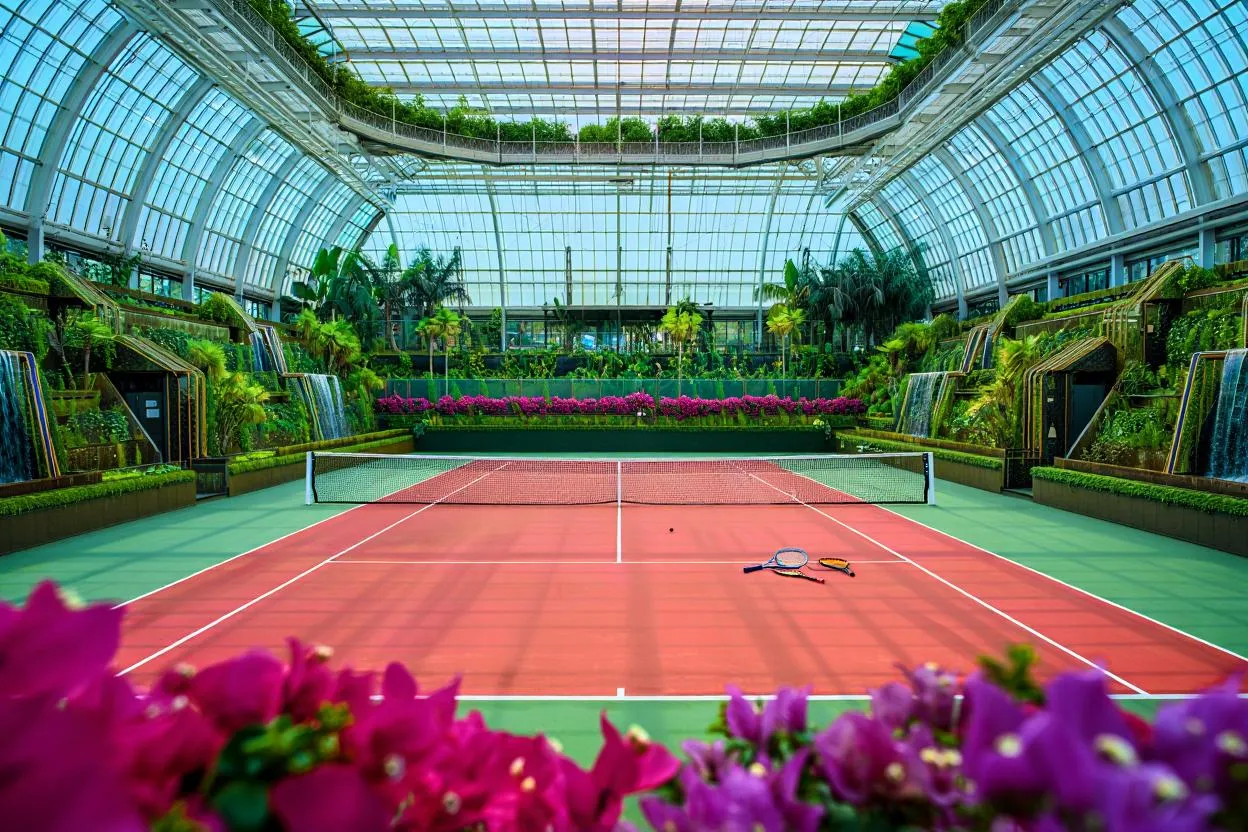
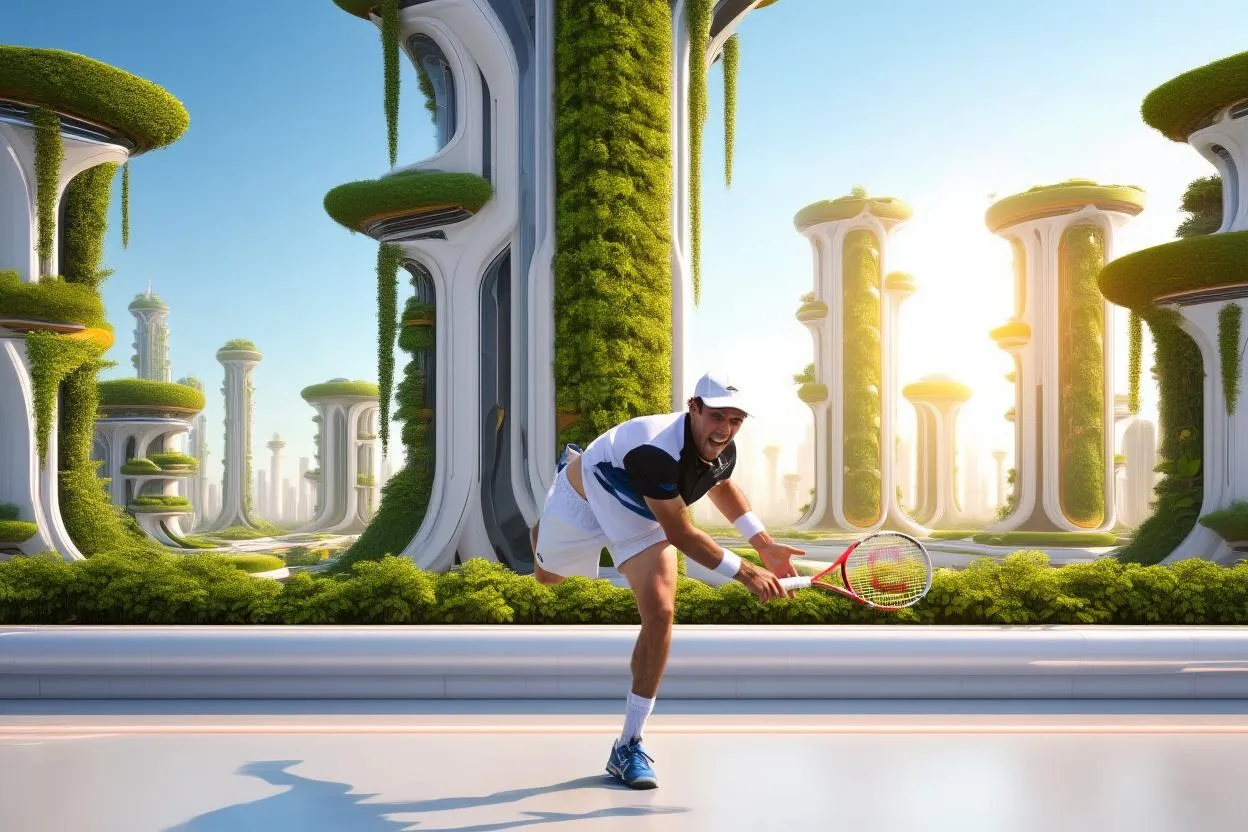
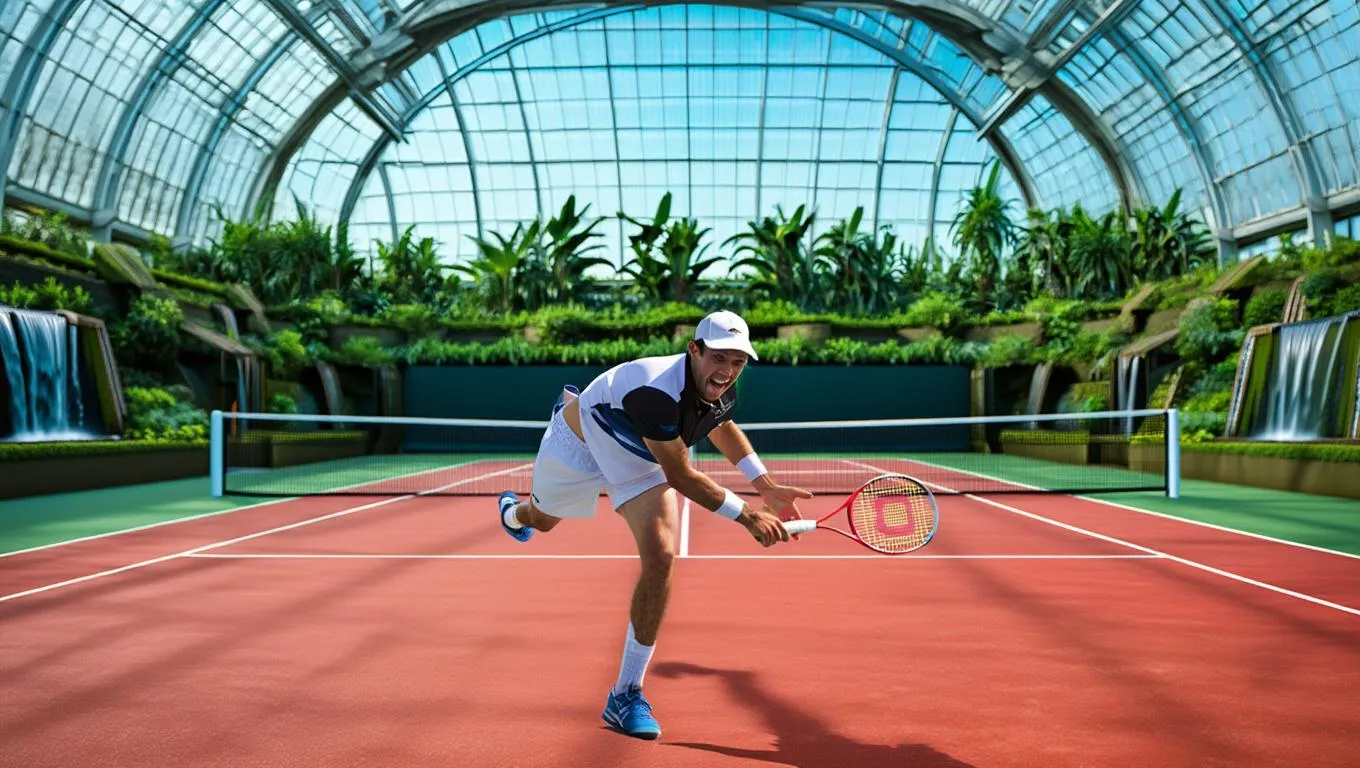

In [23]:
spunk_t.select(spunk_t.new_image, spunk_t.edited_subject, spunk_t.solarpunk_remix).collect()

## Review Reve in Pixeltable

Below is a quick recap of how each Reve function maps inputs to outputs inside Pixeltable tables. Each function reads input parameters and writes its results into computed columns.

### `reve.create()`

- **Input parameter:** A prompt inserted as a row inside a Pixeltable


prompt  \
0  Create a scene of lush solarpunk metropolis in...   
1  Create an indoor tennis court scene, with clay...   

                                           new_image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                        new_image_sq  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
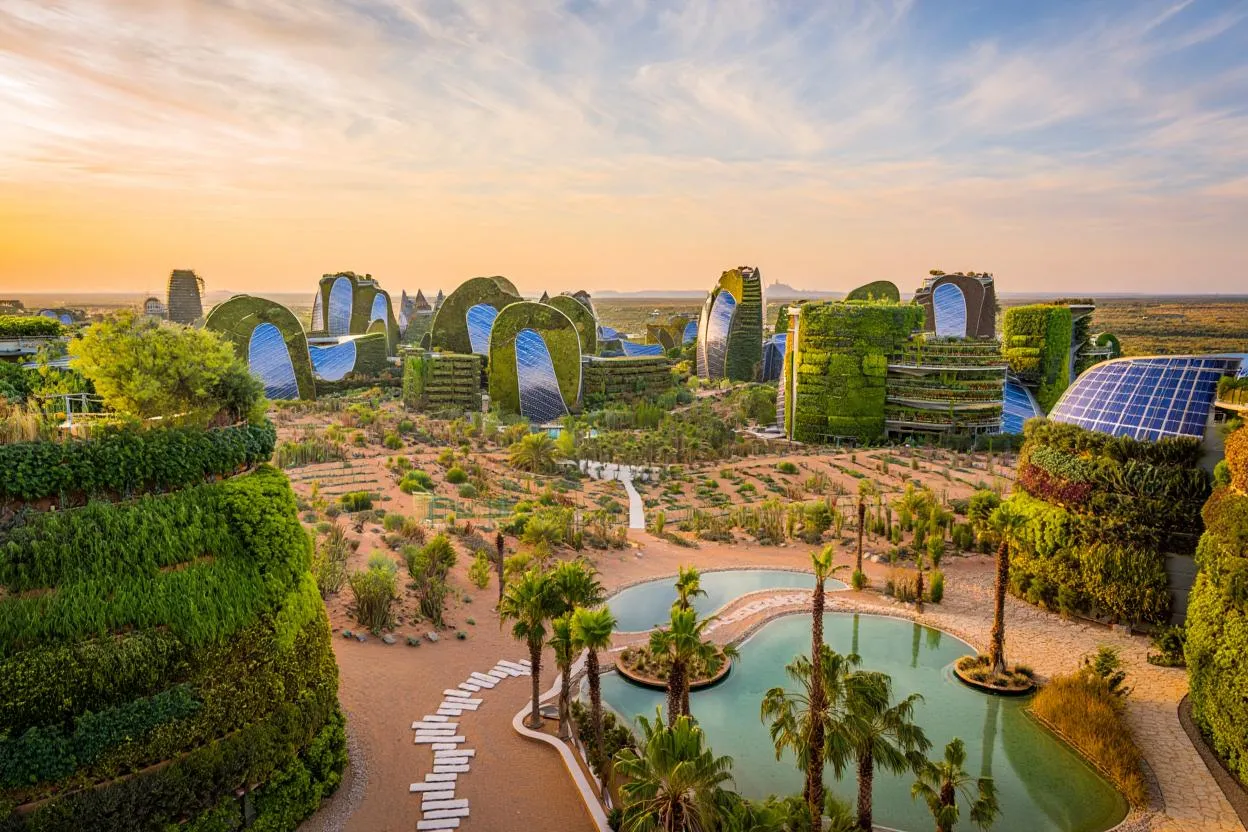
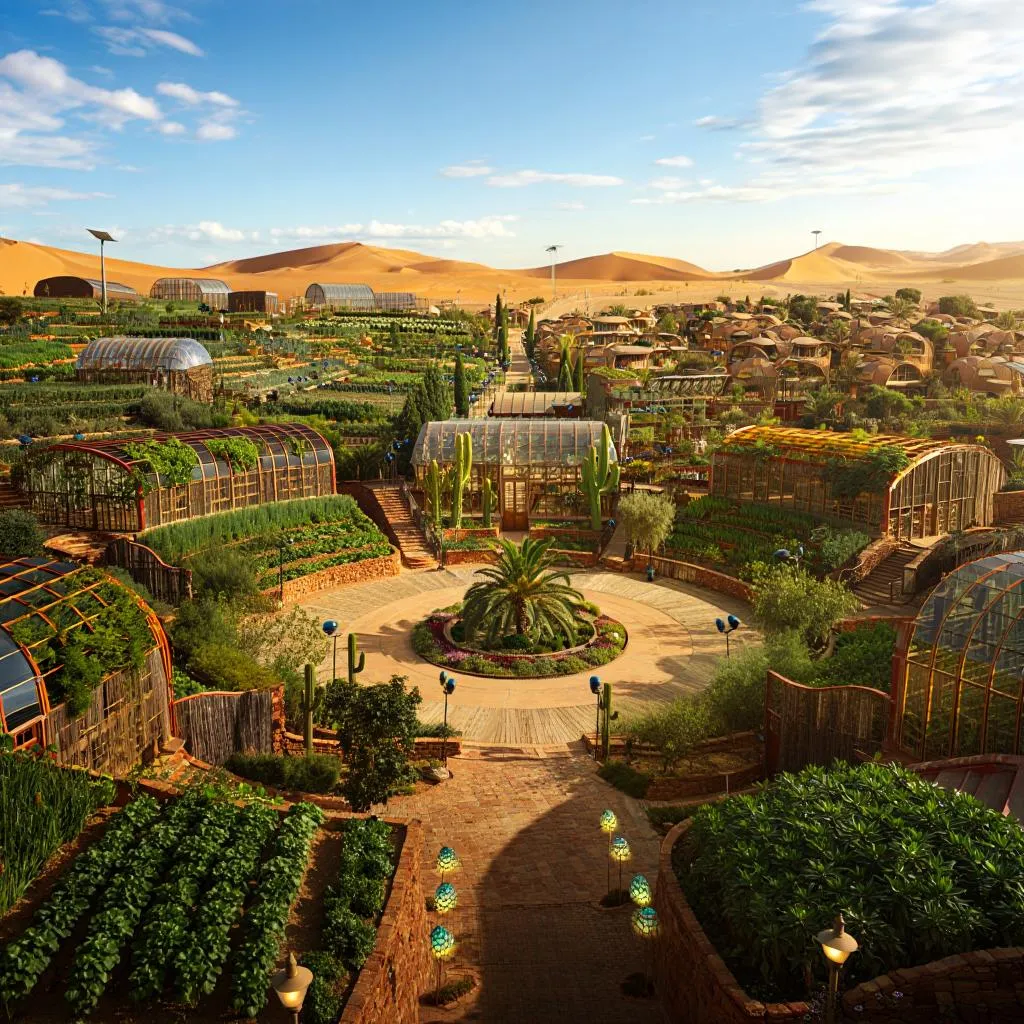
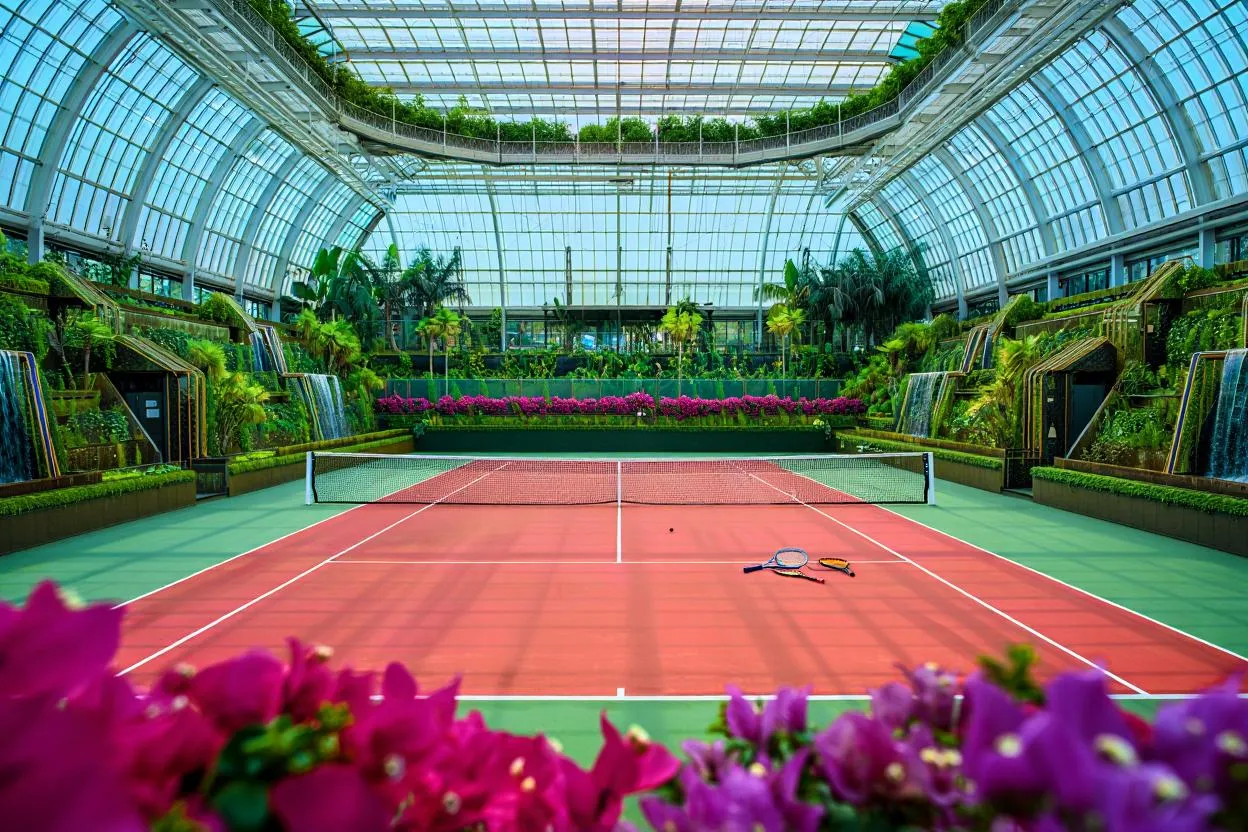
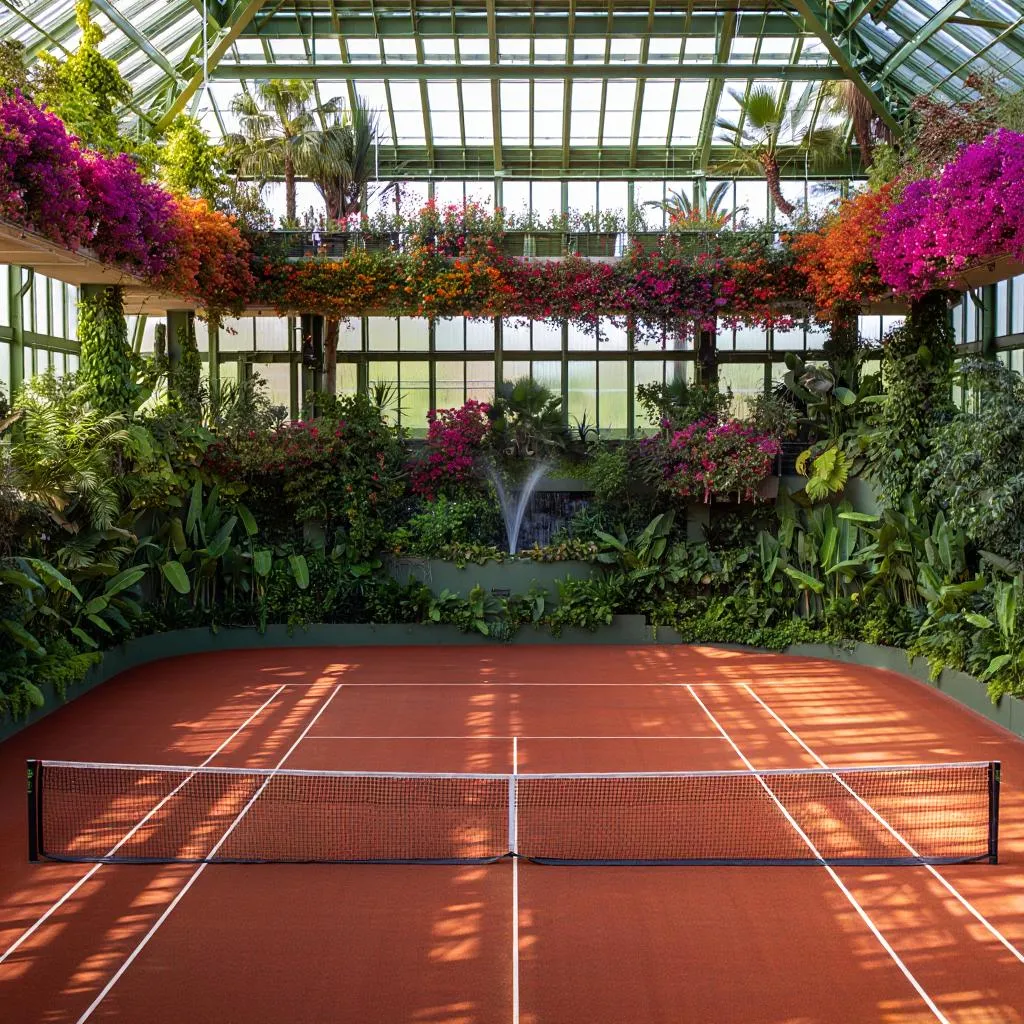

In [24]:
spunk_t.select(
    spunk_t.prompt,
    spunk_t.new_image,
    spunk_t.new_image_sq,
).collect()

### `reve.edit()`

- **Input parameter:** A source image of type `pxt.Image`
- **Usage reminder:** The edit instructions live inline inside the `add_computed_column()` call

source_image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                      edited_subject  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
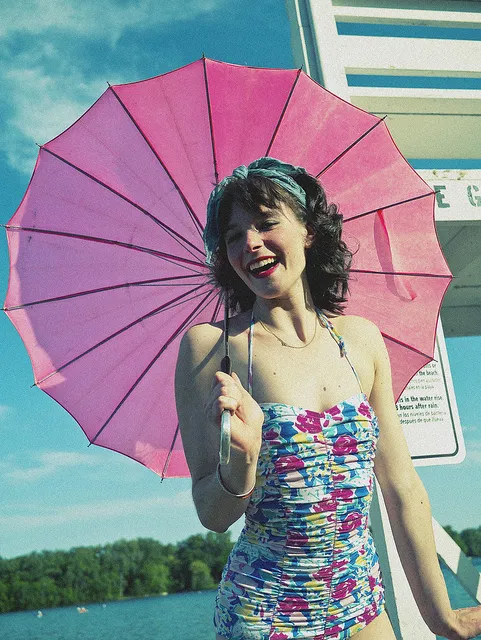
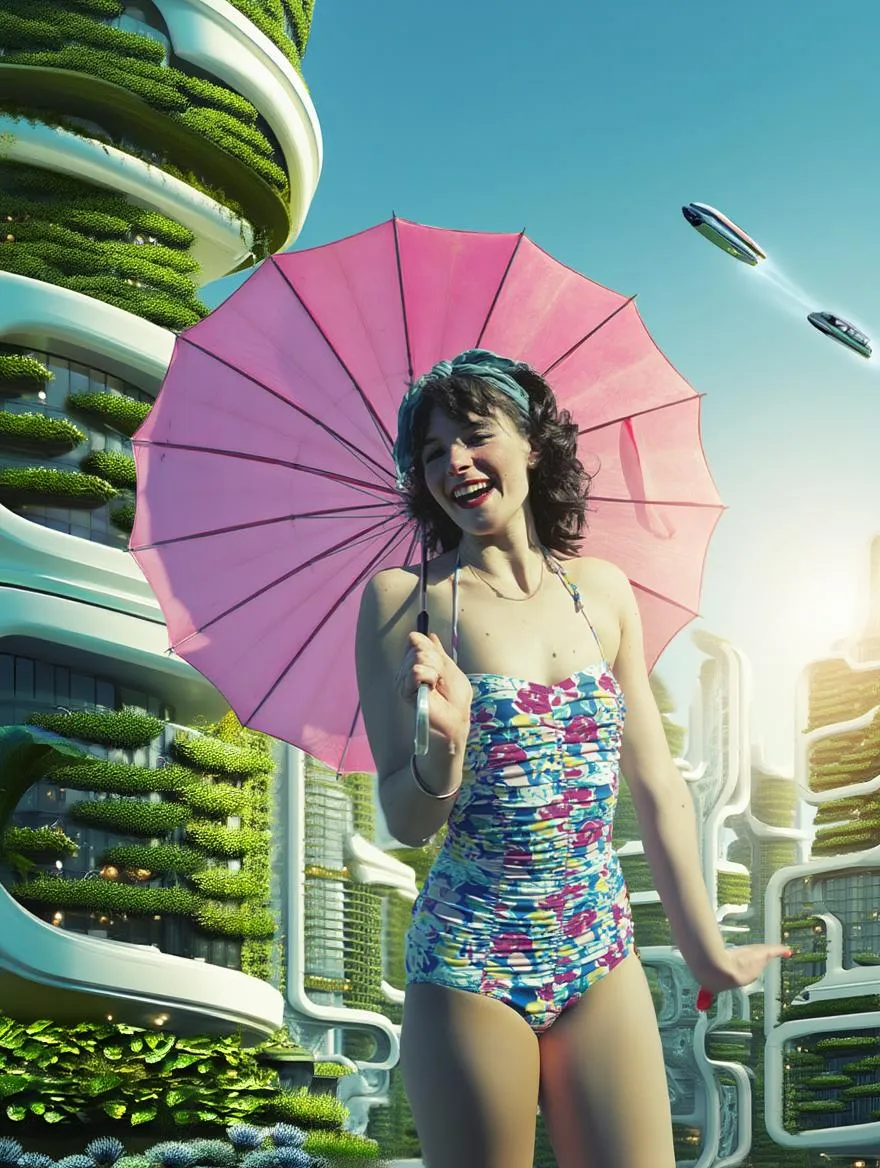
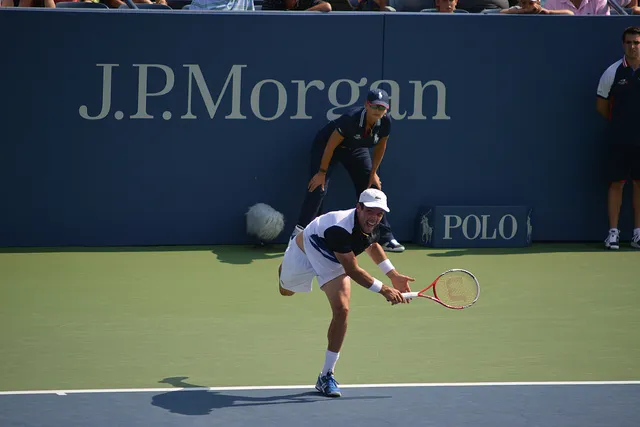
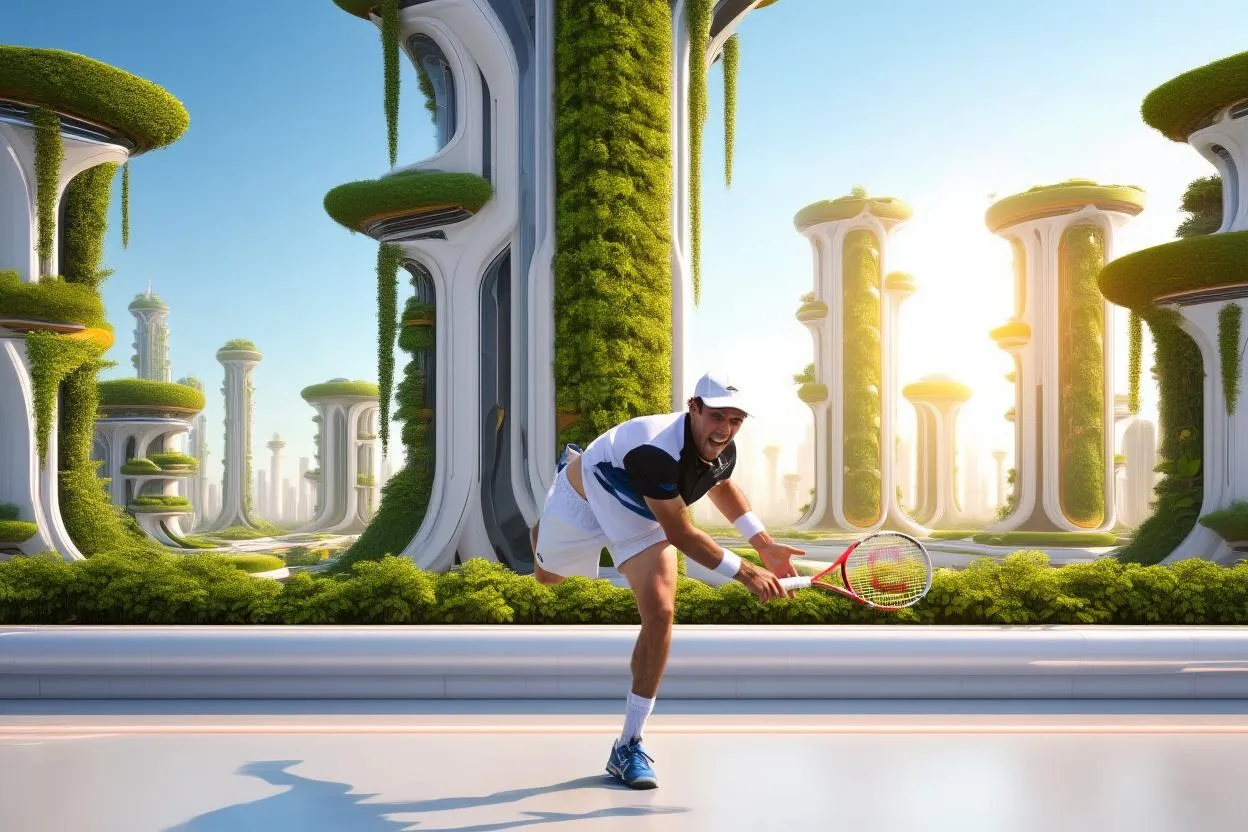

In [25]:
spunk_t.select(
    spunk_t.source_image,
    spunk_t.edited_subject,
).collect()

### `reve.remix()`

- **Input parameters:** We started with two image columns
- **How the prompt references them:**
  - `images=[my_table.image00, my_table.image01]`
  - Inside the prompt, `<img>0</img>` points at `images[0]` and `<img>1</img>` points at `images[1]`
- **Usage reminder:** Always keep the placeholders and the order of the `images` list in sync; add more `<img>n</img>` tags if you pass more reference images.

new_image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                      edited_subject  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                     solarpunk_remix  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
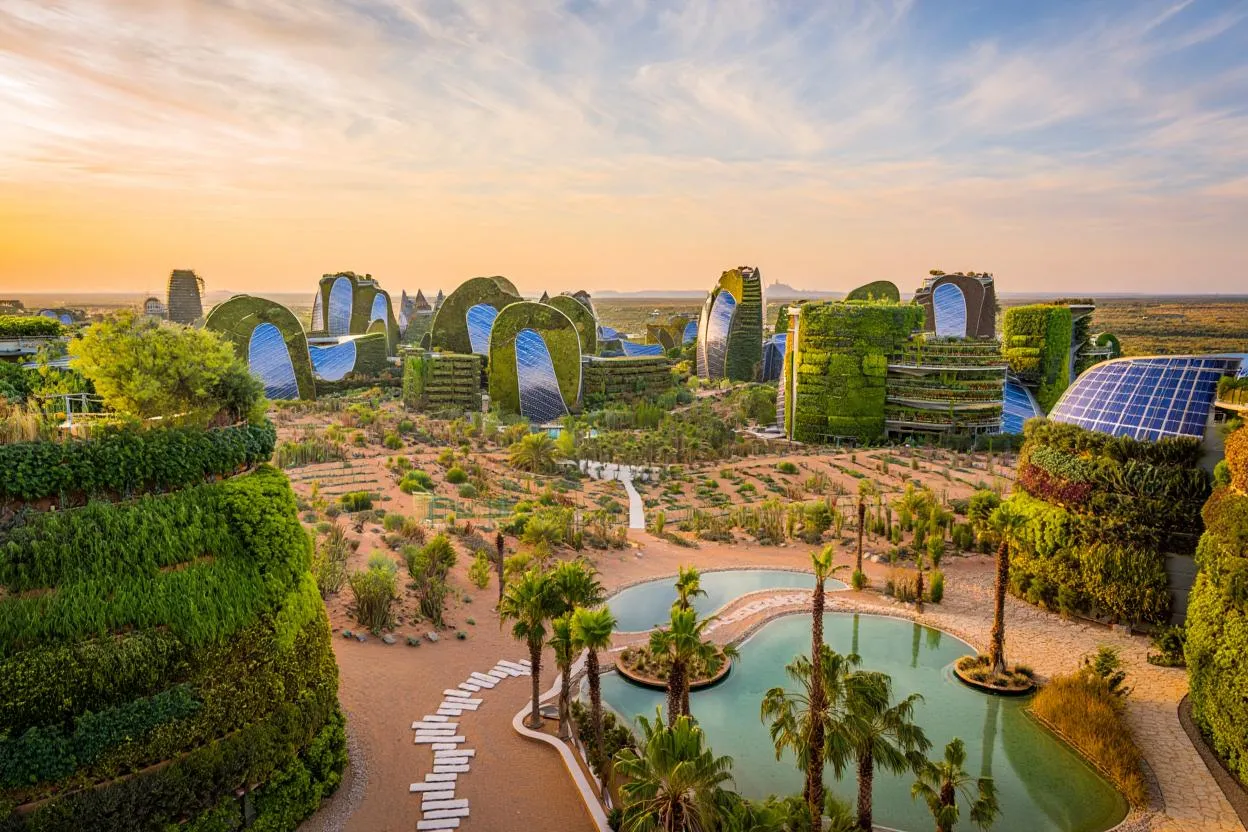
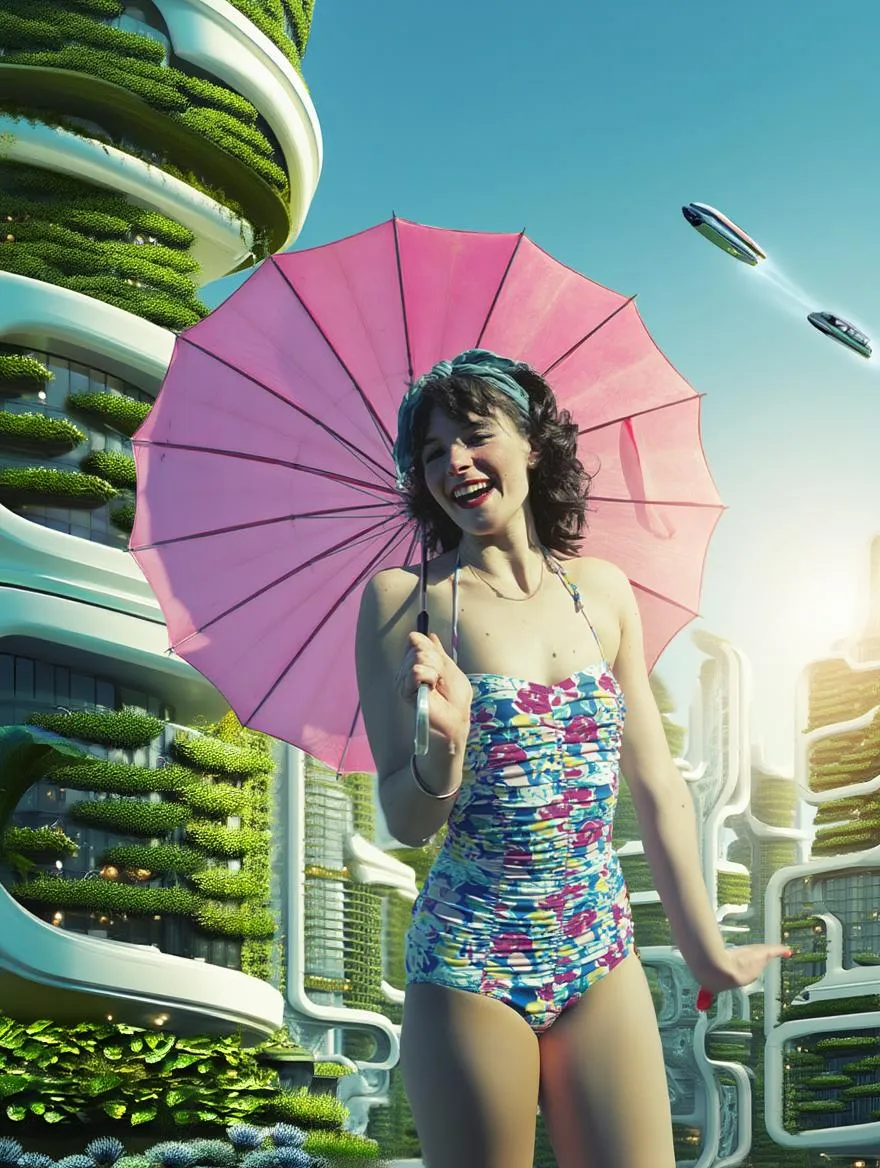
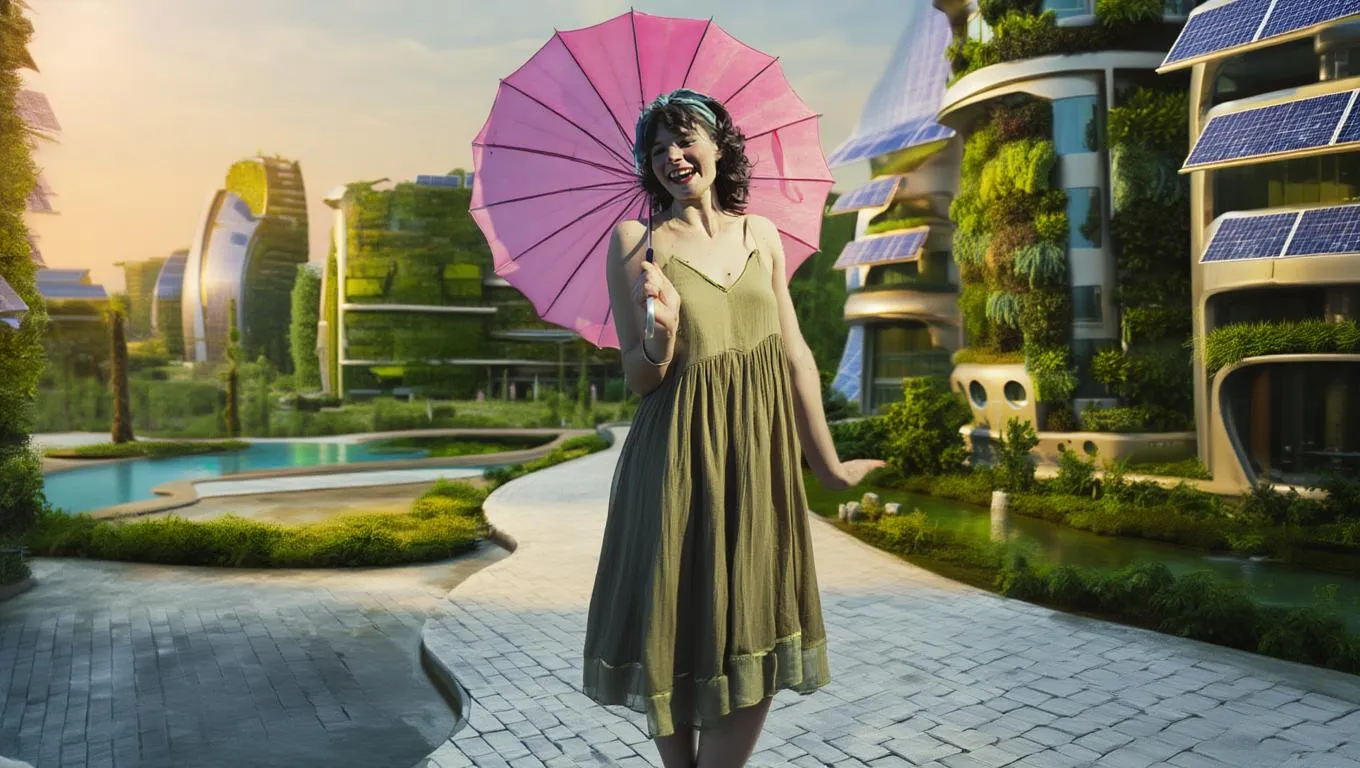
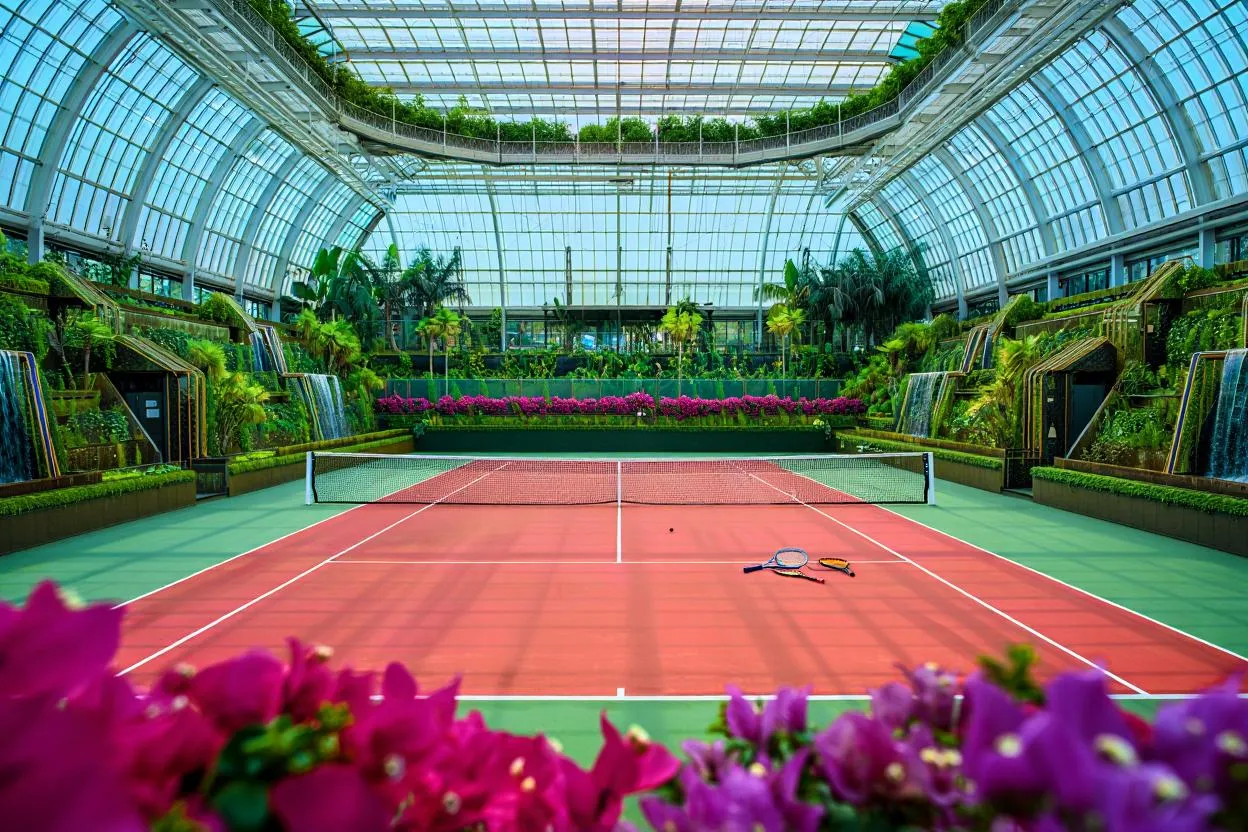
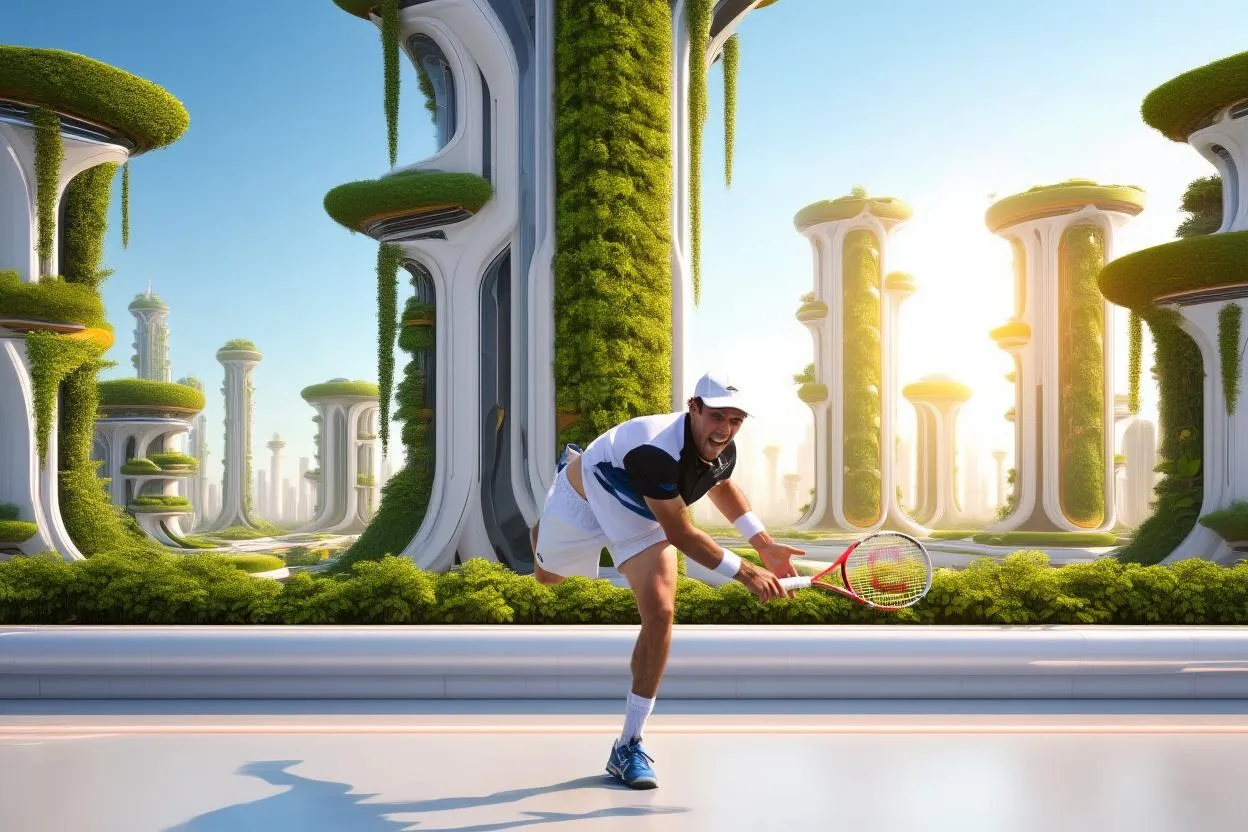
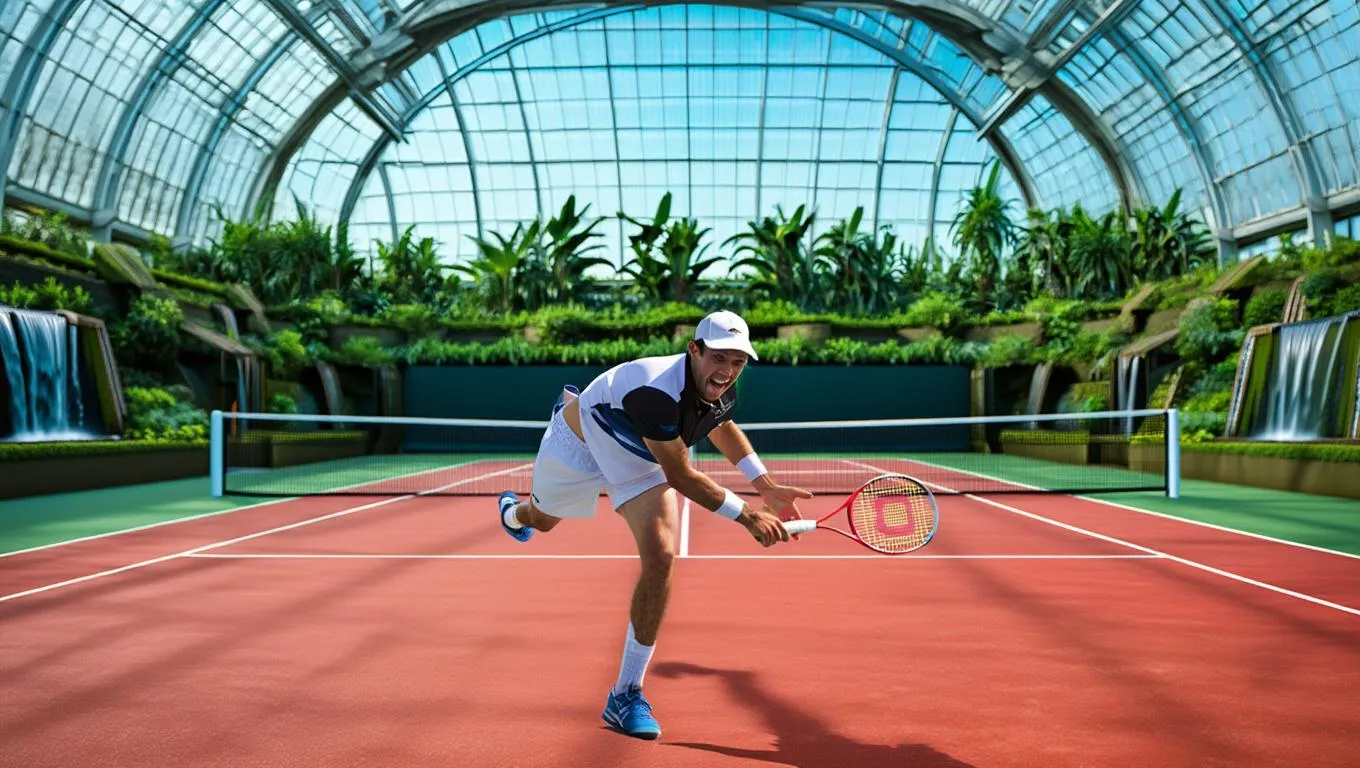

In [26]:
spunk_t.select(
    spunk_t.new_image,
    spunk_t.edited_subject,
    spunk_t.solarpunk_remix,
).collect()

## Learn more

- Reve API reference: <https://api.reve.com/console/docs>
- Pixeltable documentation: <https://docs.pixeltable.com/sdk/latest/reve#module-pixeltable-functions-reve>

If you build something with Reve, let us know!
